## ToDo

In [1]:
# add batch normalization
# see if i can improve the network
# convert tf.layers to native tensorflow
# save images generated during training for checking the convergence

## Model

In [2]:
# stretching the cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# cuda settings
import os
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.50)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
image_size = 128
dlearning_rate=0.0001
glearning_rate=0.0001
batch_size = 100

In [5]:
# with batch normalization layer
def Generator(z,reuse=None):
    
    with tf.variable_scope('gen',reuse=reuse):
        
        layer1 = tf.layers.dense(z,1024,activation=tf.nn.relu)
        # reshaping the sample to 2d
        layer1 = tf.reshape(layer1,shape=(-1,32,32,1))
        layer1_bn = tf.layers.batch_normalization(layer1)
        
        layer2 = tf.layers.conv2d(layer1_bn,filters=32,kernel_size=(3,3),strides=(1,1),padding='same',activation=tf.nn.relu,use_bias=True)
        layer2_bn = tf.layers.batch_normalization(layer2)
        
        # upsampling the data (64*64)
        layer3 = tf.layers.conv2d_transpose(layer2_bn,filters=32,kernel_size=(3,3),strides=2,padding='same',activation=tf.nn.relu)
        layer3_bn = tf.layers.batch_normalization(layer3)
        
        # simple convolution layer 64*64
        layer4 = tf.layers.conv2d(layer3_bn,filters=64,kernel_size=(3,3),strides=1,padding='same',activation=tf.nn.relu)
        # not applying batch_norm to generator output layer
        
        # output shape (-1,128,128,3)
        output = tf.layers.conv2d_transpose(layer4,filters=3,kernel_size=(3,3),strides=2,padding='same',activation=tf.nn.tanh)
        
        #(-1,128,128,3)
        return output

In [6]:
def Discriminator(X,reuse=None):
    
    with tf.variable_scope('dis',reuse=reuse):

        # not applying batch norm to discrimator input layer
        layer1 = tf.layers.conv2d(X,filters=32,kernel_size=(3,3),strides=1,padding='same',activation=tf.nn.leaky_relu)
        #downsampling to half 64*64
        layer1 = tf.layers.conv2d(layer1,filters=32,kernel_size=(3,3),strides=2,padding='same',activation=tf.nn.leaky_relu)
        layer1_bn = tf.layers.batch_normalization(layer1)

        layer2 = tf.layers.conv2d(layer1_bn,filters=64,kernel_size=(3,3),strides=1,padding='same',activation=tf.nn.leaky_relu)
        # downsampling to half 32*32
        layer2 = tf.layers.conv2d(layer2,filters=64,kernel_size=(3,3),strides=2,padding='same',activation=tf.nn.leaky_relu)
        layer2_bn = tf.layers.batch_normalization(layer2)
        

        layer3 = tf.layers.conv2d(layer2_bn,filters=128,kernel_size=(3,3),strides=1,padding='same',activation=tf.nn.leaky_relu)
        # downsampling to half 16*16
        layer3 = tf.layers.conv2d(layer3,filters=128,kernel_size=(3,3),strides=2,padding='same',activation=tf.nn.leaky_relu)
        layer3_bn = tf.layers.batch_normalization(layer3)
        
        
        # downsampling to half 8*8
        layer4 = tf.layers.conv2d(layer3_bn,filters=128,kernel_size=(3,3),strides=2,padding='same',activation=tf.nn.leaky_relu)
        layer4_bn = tf.layers.batch_normalization(layer4)
        

        # fully connected layer 1*1*1024
        layer5 = tf.layers.conv2d(layer4_bn,filters=1024,kernel_size=(8,8),strides=1,padding='valid',activation=tf.nn.leaky_relu)
        layer5_bn = tf.layers.batch_normalization(layer5)
        

        # final output layer 1
        output = tf.layers.conv2d(layer5_bn,filters=1,kernel_size=(1,1),strides=1,padding='valid')
        
        return output

In [20]:
# placeholders
with tf.name_scope('placeholders'):
    # input image placholder
    real_image=tf.placeholder(tf.float32,shape=(None,128,128,3),name='real_image')
    # random sample placeholder
    z = tf.placeholder(tf.float32,shape=(None,100),name='z')

In [21]:
# logits
fake_image = Generator(z)

real_logit = Discriminator(real_image)
fake_logit = Discriminator(fake_image,reuse=True)

In [22]:
# losses and optimizers
with tf.name_scope('losses'):
    rloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logit,labels=tf.ones_like(real_logit)*0.9))
    floss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logit,labels=tf.zeros_like(fake_logit)*0.1))
    
    dloss = rloss+floss
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logit,labels=tf.ones_like(fake_logit)*0.9))

In [23]:
with tf.name_scope('varaibles'):
    allvars = tf.trainable_variables()
    dvars = [var for var in allvars if 'dis' in var.name]
    gvars = [var for var in allvars if 'gen' in var.name]

In [24]:
with tf.variable_scope('optimizers',reuse=tf.AUTO_REUSE):
    doptimizer = tf.train.AdamOptimizer(learning_rate=dlearning_rate).minimize(dloss,var_list=dvars)
    goptimizer = tf.train.AdamOptimizer(learning_rate=glearning_rate).minimize(gloss,var_list=gvars)

In [25]:
# input queue 
import glob
image_path = glob.glob('data/celebA/*.jpg')

Dataset =  tf.data.Dataset
Iterator = tf.data.Iterator

train_data = Dataset.from_tensor_slices(image_path)

def input_parser(img_path):
    # read the img from file
    img_file = tf.read_file(img_path)
    img_decoded = tf.image.decode_image(img_file, channels=3)
    img_reshaped = tf.image.resize_image_with_crop_or_pad(img_decoded,target_height=128,target_width=128)

    return img_reshaped

def input_preprocess(img):
    img = tf.divide(img,255)
    img = tf.subtract(tf.multiply(img,2),1) # scaling the image in the tanh range
    
    return img

train_data = train_data.map(input_parser)
train_data = train_data.map(input_preprocess)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(1)
iterator = Iterator.from_structure(train_data.output_types,train_data.output_shapes)
next_element = iterator.get_next()

training_init_op = iterator.make_initializer(train_data)
init_op = tf.global_variables_initializer()

In [27]:
generated_images=[]
total_epoch = 100

In [ ]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    saver = tf.train.Saver()
    sess.run(init_op)
    for epoch in range(total_epoch):
    
        sess.run(training_init_op)
        i=0
        print("Started training ... .! \n")
        while True:
            try:
                # get the images
                ximage = sess.run(next_element)
                xsample = np.random.uniform(-1.,1.,size=(batch_size,100))
                sess.run(doptimizer,feed_dict={real_image:ximage,z:xsample})
                sess.run(goptimizer,feed_dict={z:xsample})
                i+=1
                if(i%1000==0):
                    # tracking the image quality after (i) epoch
                    cur_sample = np.random.uniform(-1,1,size=(1,100))
                    gen_sample = sess.run(fake_image,feed_dict={z:cur_sample})
                    generated_images.append(gen_sample)
                    
                if(i%500==0):
                    l1 = sess.run(dloss,feed_dict={real_image:ximage,z:xsample})
                    l2 = sess.run(gloss,feed_dict={z:xsample})
                    print("after {} iterations --> losses : Descriptor : {} Generator : {}\n".format(i,l1,l2))
            
            except tf.errors.OutOfRangeError:
                print("End of training dataset.")
                break
                
        print("On Epoch {}\n".format(epoch))
    saver.save(sess,'saved_models/dcgan.ckpt')

Started training ... .! 

after 500 iterations --> losses : Descriptor : 0.32522934675216675 Generator : 8.376692771911621

after 1000 iterations --> losses : Descriptor : 0.46592772006988525 Generator : 5.538253307342529

after 1500 iterations --> losses : Descriptor : 0.3265942335128784 Generator : 6.722678184509277

after 2000 iterations --> losses : Descriptor : 0.325532466173172 Generator : 10.458595275878906

End of training dataset.
On Epoch 0

Started training ... .! 

after 500 iterations --> losses : Descriptor : 0.33380115032196045 Generator : 6.6337103843688965

after 1000 iterations --> losses : Descriptor : 0.32941368222236633 Generator : 6.690486431121826

after 1500 iterations --> losses : Descriptor : 0.33054137229919434 Generator : 6.376743316650391

after 2000 iterations --> losses : Descriptor : 0.34106460213661194 Generator : 4.8663330078125

End of training dataset.
On Epoch 1

Started training ... .! 

after 500 iterations --> losses : Descriptor : 0.353776454925

after 1000 iterations --> losses : Descriptor : 0.3263322412967682 Generator : 11.069705963134766

after 1500 iterations --> losses : Descriptor : 0.3269835412502289 Generator : 9.365203857421875

after 2000 iterations --> losses : Descriptor : 0.3292219042778015 Generator : 9.463854789733887

End of training dataset.
On Epoch 19

Started training ... .! 

after 500 iterations --> losses : Descriptor : 0.3302139639854431 Generator : 15.998601913452148

after 1000 iterations --> losses : Descriptor : 0.32604652643203735 Generator : 10.287772178649902

after 1500 iterations --> losses : Descriptor : 0.3261083960533142 Generator : 12.160059928894043

after 2000 iterations --> losses : Descriptor : 0.3534143269062042 Generator : 9.033339500427246

End of training dataset.
On Epoch 20

Started training ... .! 

after 500 iterations --> losses : Descriptor : 0.36314424872398376 Generator : 14.094511985778809

after 1000 iterations --> losses : Descriptor : 0.3278381824493408 Generator : 8.35

after 1000 iterations --> losses : Descriptor : 0.3271622061729431 Generator : 12.691389083862305



In [32]:
len(generated_images)

115

In [ ]:
ls

## Testing the generated images

In [30]:
# getting back to 255 range
new_images = list(map(lambda x : np.squeeze(x),generated_images))
new_images = list(map(lambda x : ((x+1)/2)*255,new_images))
new_images = list(map(lambda x: x.astype(int),new_images))

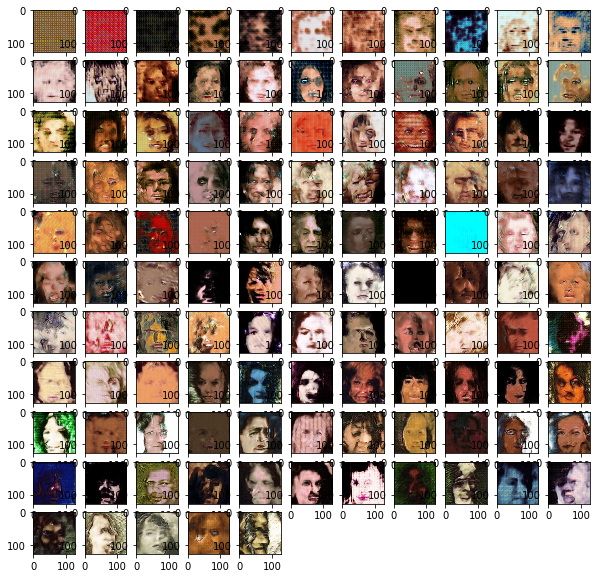

In [33]:
# plotting the generated image
plt.figure(figsize=(10,10))
for i in range(len(generated_images)):
    plt.subplot(11,11,i+1)
    plt.imshow(new_images[i])
plt.show()